# ALOS - Lidar Texture Learning (multiple scales)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages</a></span></li><li><span><a href="#Setup-data" data-toc-modified-id="Setup-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup data</a></span></li><li><span><a href="#CNN-models" data-toc-modified-id="CNN-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>CNN models</a></span><ul class="toc-item"><li><span><a href="#Start-with-the-1500m-resolution-data" data-toc-modified-id="Start-with-the-1500m-resolution-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Start with the 1500m resolution data</a></span><ul class="toc-item"><li><span><a href="#Learning-using-HH/HV/angle" data-toc-modified-id="Learning-using-HH/HV/angle-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Learning using HH/HV/angle</a></span></li><li><span><a href="#RF-using-CNN-features" data-toc-modified-id="RF-using-CNN-features-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>RF using CNN features</a></span></li></ul></li><li><span><a href="#Test-all-other-resolutions" data-toc-modified-id="Test-all-other-resolutions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Test all other resolutions</a></span></li></ul></li><li><span><a href="#Multi-resolution-comparison" data-toc-modified-id="Multi-resolution-comparison-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Multi-resolution comparison</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Import packages

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#%% import modules
from pathlib import Path

import dask.dataframe as dd
import pandas as pd
import torch.nn as nn
import xarray as xr
from fastai import *
from fastai.vision import *

import a1902alos.data_load as adl
import a1902alos.deep_mdl as adm
import a1902alos.grid_models as gridm

In [4]:
import torch

print(torch.cuda.device_count())
print(torch.cuda.get_device_name())
torch.cuda.empty_cache()

2
GeForce GTX 1080 Ti


In [5]:
torch.device("cuda")

device(type='cuda')

In [6]:
p = Path("E:/data00/a1902alostexture/data3")
# p = Path("/media/xuliang/Data01/data00/a1902alostexture/data3")

## Setup data

* DRC Lidar transects at multiple spatial resolutions
* Pixel is valid only when 60% of the pixel area is covered by Lidar
* ALOS layers registered to Lidar resolutions
* Total valid Lidar MCH samples
    - 1500m: 1062  samples (67x67)
    - 1000m: 2768  samples (45x45)
    - 700m: 6011  samples (32x32)
    - 400m: 19203 samples (18x18)
    - 100m: 323126 samples (5x5)


## CNN models

### Start with the 1500m resolution data

In [7]:
#%% setup databunch

NR = [0.001, 0.003, 0.005, 0.007, 0.01, 0.013, 0.016, 0.02]  # different resolutions
# NR = [0.001]
for ires in NR:  # different resolutions
    in_file = str(p / f"output/africa25m_{ires}deg_training_samples.pqt")
    df0 = pd.read_parquet(in_file)
    print(df0.shape)
    
    imgsize = int(np.ceil(ires / 0.0002246))
    print(imgsize)
    x_file = str(p / "africa25m_1517.zarr")
    x1path = str(p / f"training_{ires}")
    df1 = adl.get_image_from_df(df0, x_file, x1path, cols=("y", "x"), blocksize=(-ires, ires))
    df1.to_parquet(f"{in_file[:-4]}_xfiles.pqt", compression="snappy", engine="fastparquet")


(322708, 4)
5
Done
(34848, 4)
14
Done
(12204, 4)
23
Done
(6024, 4)
32
Done
(2743, 4)
45
Done
(1551, 4)
58
Done
(947, 4)
72
Done
(505, 4)
90
Done


In [6]:
ires = 0.02
in_file = str(p / f"output/africa25m_{ires}deg_training_samples_xfiles.pqt")
df0 = pd.read_parquet(in_file)
df0

y        x     count        mch  \
index                                          
27554   4.8613  26.2115  0.638941   7.481188   
29514   4.8213  27.0515  0.663043  13.519005   
25638   4.9013  26.2515  0.617754  12.215304   
26596   4.8813  26.2315  0.737319  11.530825   
30315   4.8013  23.8915  0.657609  12.373228   
32235   4.7613  23.9315  0.727788  15.847306   
33195   4.7413  23.9515  0.623188  11.934417   
28555   4.8413  27.0515  0.724008  16.809563   
47652   4.4413  25.3915  0.730072  21.828644   
31275   4.7813  23.9115  0.754253  15.028851   
45733   4.4813  25.3715  0.680529  23.473389   
51599   4.3613  27.6115  0.661626  11.696914   
52558   4.3413  27.6115  0.716446  17.498585   
73642   3.9013  27.3315  0.686200   7.362869   
74600   3.8813  27.3115  0.635161   6.911902   
53517   4.3213  27.6115  0.697543  15.728348   
75676   3.8613  29.6515  0.724638   6.921676   
77254   3.8213  22.8515  0.693762  17.811487   
77593   3.8213  29.6315  0.744802   4.430572   
82166   3.7213  25.1915  0.727788  11.887753   
87114   3.6213  28.2515  0.704710   5.690553   
86156   3.6413  28.2715  0.730072   5.682338   
83762   3.6813  18.7515  0.692708  27.267195   
84723   3.6613  18.7915  0.671077  25.573792   
88072   3.6013  28.2315  0.750473  10.775987   
90737   3.5413  23.9915  0.692029  23.389671   
90824   3.5413  25.7315  0.731884  19.200897   
91699   3.5213  24.0515  0.742754  21.172865   
91867   3.5213  27.4115  0.610586  26.293541   
91782   3.5213  25.7115  0.653986  19.991579   
...        ...      ...       ...        ...   
512772 -5.2587  25.4915  0.682420  17.654633   
511812 -5.2387  25.4715  0.715278   7.144795   
510053 -5.1987  28.6515  0.677536   8.385925   
515436 -5.3187  21.2315  0.711957  20.401371   
515764 -5.3187  27.7915  0.708333  28.559675   
516396 -5.3387  21.2515  0.722826  25.116068   
517228 -5.3587  18.7115  0.635161  17.776089   
516721 -5.3387  27.7515  0.641304  30.547529   
517679 -5.3587  27.7315  0.748582  32.723278   
518188 -5.3787  18.7315  0.733459  10.753973   
521050 -5.4387  18.4315  0.648393  11.516571   
520091 -5.4187  18.4315  0.708885  12.510670   
521165 -5.4387  20.7315  0.667297   1.899753   
522123 -5.4587  20.7115  0.720486   2.347663   
523081 -5.4787  20.6915  0.748582   3.749641   
525131 -5.5187  23.3315  0.648393  20.773081   
524173 -5.4987  23.3515  0.748582  21.824425   
532054 -5.6587  27.5315  0.711957   6.311161   
539328 -5.8187  19.5715  0.643116   5.316620   
533012 -5.6787  27.5115  0.733459   8.610141   
549156 -6.0187  24.3315  0.674858   4.584979   
540287 -5.8387  19.5715  0.684028   0.795602   
552034 -6.0787  24.3515  0.663194   5.400606   
552993 -6.0987  24.3515  0.695652   4.893163   
581614 -6.6987  21.3715  0.737240   6.244680   
561511 -6.2787  22.0915  0.754253   8.506663   
562471 -6.2987  22.1115  0.672101   5.183258   
585237 -6.7787  17.1115  0.663516  22.397829   
586196 -6.7987  17.1115  0.621928  24.975834   
582575 -6.7187  21.4115  0.748582  10.020851   

                                        x_files  
index                                            
27554                           /4.8613_26.2115  
29514                           /4.8213_27.0515  
25638                           /4.9013_26.2515  
26596                           /4.8813_26.2315  
30315                           /4.8013_23.8915  
32235                           /4.7613_23.9315  
33195                /4.7413_23.951500000000003  
28555                           /4.8413_27.0515  
47652                           /4.4413_25.3915  
31275                           /4.7813_23.9115  
45733                           /4.4813_25.3715  
51599                           /4.3613_27.6115  
52558                           /4.3413_27.6115  
73642                           /3.9013_27.3315  
74600    /3.8813000000000004_27.311500000000002  
53517                           /4.3213_27.6115  
75676                /3.8613_29.651500000000002  
77254                           /3.821

#### Learning using HH/HV/angle

In [7]:
#%% setup databunch

# for ires in [0.001, 0.004, 0.007, 0.01, 0.015]:  # different resolutions
for ires in [0.02]:  # different resolutions
    in_file = str(p / f"output/africa25m_{ires}deg_training_samples_xfiles.pqt")
    df0 = pd.read_parquet(in_file)

    imgsize = int(np.ceil(ires / 0.0002246))
    print(imgsize)
    x_file = str(p / "alos2africa_ds.zarr")
    x1path = str(p / f"training_{ires}")
    data = adl.get_databunch_from_df_training(
        df0,
        x1path,
        label="mch",
        test_df=None,
        dbsize=imgsize,
        bs=16,
    )


90
MultiChannelImageListFolder (505 items)
Image (4, 89, 158),Image (4, 89, 160),Image (4, 89, 159),Image (4, 89, 156),Image (4, 89, 155)
Path: E:\data00\a1902alostexture\data3\training_0.02


In [7]:
df0.x_files.iloc[0]

'/4.84831052628455_27.049925362625107'

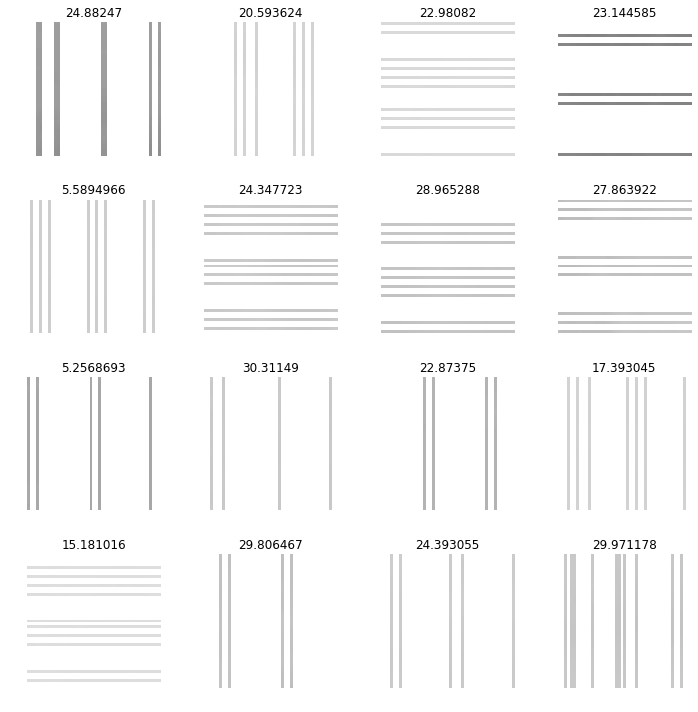

In [12]:
data.show_batch(figsize=(10, 10))
plt.savefig(p / f"output/data_batch_{ires}deg.png", dpi=150)


In [ ]:
data.batch_stats()

In [15]:
data.normalize()

ImageDataBunch;

Train: LabelList (404 items)
x: MultiChannelImageListFolder
Image (4, 90, 90),Image (4, 90, 90),Image (4, 90, 90),Image (4, 90, 90),Image (4, 90, 90)
y: FloatList
7.481188,13.519005,12.215304,11.530825,11.934417
Path: E:\data00\a1902alostexture\data3\training_0.02;

Valid: LabelList (101 items)
x: MultiChannelImageListFolder
Image (4, 90, 90),Image (4, 90, 90),Image (4, 90, 90),Image (4, 90, 90),Image (4, 90, 90)
y: FloatList
31.339634,5.9471025,24.926579,15.847306,15.197023
Path: E:\data00\a1902alostexture\data3\training_0.02;

Test: None

In [9]:
bnd1 = 4


class L1LossFlat(nn.L1Loss):
    def forward(self, input: Tensor, target: Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))


model = nn.Sequential(
    adm.conv1(bnd1, 4),
    res_block(4),
    adm.conv2(4, 16),
    res_block(16),
    adm.conv2(16, 64),
    res_block(64),
    PoolFlatten(),
    nn.Linear(64, 1),
)

model2 = models.WideResNet(
    num_groups=6,
    N=3,
    num_classes=1,
    start_nf=bnd1 * 4,
    k=1,
    n_in_channels=bnd1,
#     drop_p=0.2,
)

# learn = cnn_learner(
#     data, models.resnet34, pretrained=False, 
#     loss_func=L1LossFlat(), lin_ftrs=[512], ps=0.2,
#     metrics=[mean_squared_error],
#     path=str(p / f"output/learn_{ires}deg2"))

learn = cnn_learner(
    data, model2, pretrained=False, cut=-2,
    loss_func=L1LossFlat(), lin_ftrs=[512], ps=0.2,
    metrics=[mean_squared_error],
    path=str(p / f"output/learn_{ires}deg4"))

# learn = cnn_learner(data, models.resnet18, path="../output/")
# learn = Learner(data, model, path="../output/")
# learn = Learner(data, model, loss_func = MSELossFlat(), metrics=[mean_squared_error], path="../output/")
# learn = Learner(data, model2, loss_func = L1LossFlat(), metrics=[mean_squared_error], path="../output/")
# learn = Learner(
#     data,
#     model2,
#     loss_func=L1LossFlat(),
#     metrics=[mean_squared_error],
#     path=str(p / f"output/learn_{ires}deg"),
# )

learn.loss_func

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not bool

In [17]:
learn.summary()

RuntimeError: Given groups=1, weight of size 64 3 7 7, expected input[1, 4, 90, 90] to have 3 channels, but got 4 channels instead

In [32]:
layers = flatten_model(learn.model)
custom_hook = callbacks.hook_output(layers[-8])
layers[-8]

Flatten()

In [33]:
print(len(layers))

100


In [34]:
#%% training
learn.lr_find(end_lr=1000)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.16E-07


3.162277660168379e-07

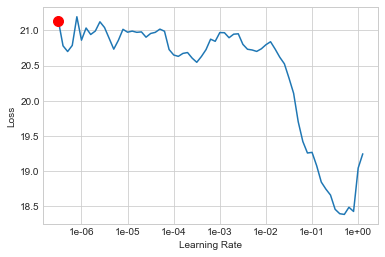

In [38]:
learn.recorder.plot(suggestion=True, skip_start=5, skip_end=8)
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

In [39]:
learn.fit_one_cycle(20, 0.1)

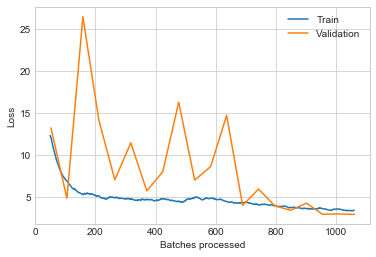

In [40]:
learn.recorder.plot_losses(skip_start=50)

In [41]:
preds, y = learn.get_preds()

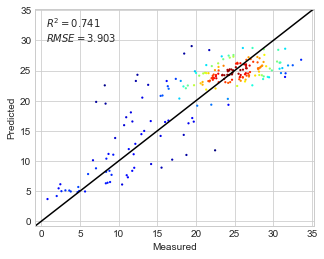

(0.7412335239895125, 3.90259)

In [42]:
gridm.density_scatter_plot(
    y.numpy().flatten(),
    preds.numpy().flatten(),
    file_name=str(p / f"output/learn_{ires}deg2_alos_val_densityplot.png"),
)

In [20]:
os.getcwd()

'E:\\Codes\\pcprojects\\a1902_alostexture\\tests'

In [43]:
learn.save("trained_model", return_path=True)

WindowsPath('E:/data00/a1902alostexture/data3/output/learn_0.015deg2/models/trained_model.pth')

#### RF using CNN features

In [46]:
in_file = str(p / f"output/africa25m_{ires}deg_training_samples_xfiles.pqt")
df0 = pd.read_parquet(in_file)
imgsize = int(np.ceil(ires / 0.0002246))
x_file = str(p / "alos2africa_ds.zarr")
x1path = str(p / f"training_{ires}")
data = adl.get_databunch_from_df_training(
    df0,
    x1path,
    label="mch",
    test_df=None,
    dbsize=imgsize,
    bs=16,
)
bnd1 = 3
# model2 = models.WideResNet(
#     num_groups=6,
#     N=3,
#     num_classes=1,
#     start_nf=bnd1 * 4,
#     k=1,
#     n_in_channels=bnd1,
#     drop_p=0.2,
# )
# learn = Learner(data, model2, loss_func=L1LossFlat(), metrics=[mean_squared_error])

learn = cnn_learner(
    data, models.resnet34, pretrained=False, 
    loss_func=L1LossFlat(), lin_ftrs=[512], ps=0.2,
    metrics=[mean_squared_error])
learn = learn.load(str(p / f"output/learn_{ires}deg2/models/trained_model"))
layers = flatten_model(learn.model)
custom_hook = callbacks.hook_output(layers[-8])

MultiChannelImageListFolder (1062 items)
Image (3, 66, 66),Image (3, 67, 67),Image (3, 67, 66),Image (3, 66, 67),Image (3, 67, 67)
Path: E:\data00\a1902alostexture\data3\training_0.015


In [47]:
from joblib import Parallel, delayed


def get_pred_layers(Xi):
    learn.predict(Xi[0])
    a0 = custom_hook.stored[0]
    b0 = Xi[1].data
    c0 = Xi[0].data.mean(dim=[1, 2])
    return a0, b0, c0


X = learn.data.train_ds
res = Parallel(n_jobs=1, verbose=1)(delayed(get_pred_layers)(Xi) for Xi in X)
a1 = [item[0] for item in res]
b1 = [item[1] for item in res]
c1 = [item[2] for item in res]

X = learn.data.valid_ds
res = Parallel(n_jobs=1, verbose=1)(delayed(get_pred_layers)(Xi) for Xi in X)
a2 = [item[0] for item in res]
b2 = [item[1] for item in res]
c2 = [item[2] for item in res]
a = a1 + a2
b = b1 + b2
c = c1 + c2

# a = []
# b = []
# c = []
# X = learn.data.train_ds
# for i in range(len(X)):
#     learn.predict(X[i][0])
#     a.append(custom_hook.stored[0])
#     b.append(X[i][1].data)
#     c.append(X[i][0].data.mean(dim=[1,2]))
# X = learn.data.valid_ds
# for i in range(len(X)):
#     learn.predict(X[i][0])
#     a.append(custom_hook.stored[0])
#     b.append(X[i][1].data)
#     c.append(X[i][0].data.mean(dim=[1,2]))

X1 = torch.stack(a).cpu().numpy()
print(X1.shape)
X2 = torch.stack(c).cpu().numpy()
print(X2.shape)
y = np.stack(b)
print(y.shape)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 850 out of 850 | elapsed:   10.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 212 out of 212 | elapsed:    2.4s finished


(1062, 1024)
(1062, 3)
(1062,)


Grid Search for pipeline of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:  6.5min finished


{'learn__max_depth': 6, 'learn__min_samples_split': 12, 'learn__n_estimators': 500, 'pca': None}
-13.20032346369901
12.852549371030138
cross-validated score: [-11.898914 -12.884334 -13.807849]
mean cv score: -12.86369900088807
(849, 1)
test score 0: 13.74312075599092


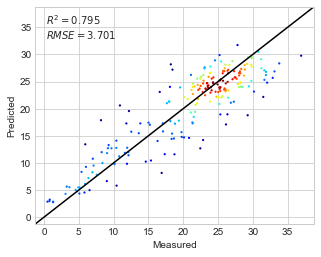

In [48]:
model_regress1 = gridm.data_train(
    X1, y, outname=str(p / f"output/rfcnn_{ires}deg2_alos")
)

Grid Search for pipeline of RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]), cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   29.1s finished


{'poly': PolynomialFeatures(degree=1, include_bias=True, interaction_only=False), 'scale': None}
-15.322314577168997


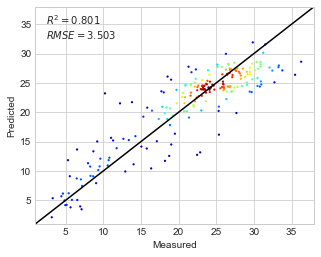

In [49]:
model_regress2 = gridm.data_train_ridge(
    X1, y, outname=str(p / f"output/ridgecnn_{ires}deg2_alos")
)

Grid Search for pipeline of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:   12.4s finished


{'learn__max_depth': 9, 'learn__min_samples_split': 2, 'learn__n_estimators': 500, 'pca': None}
-16.80105597967033
17.10180907723855
cross-validated score: [-16.702143 -16.717133 -18.473937]
mean cv score: -17.297737769353056
(849, 1)
test score 0: 24.372531267384375


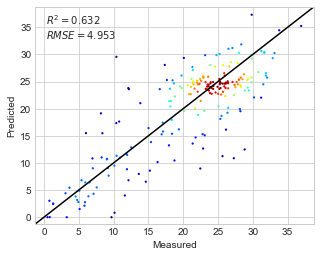

In [50]:
model_regress2 = gridm.data_train(
    X2, y, outname=str(p / f"output/rfmean_{ires}deg2_alos")
)

In [51]:
learn.destroy()


this Learner object self-destroyed - it still exists, but no longer usable


### Test all other resolutions

MultiChannelImageListFolder (323126 items)
Image (3, 5, 4),Image (3, 5, 4),Image (3, 5, 5),Image (3, 4, 4),Image (3, 5, 5)
Path: E:\data00\a1902alostexture\data3\training_0.001


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.01E-07


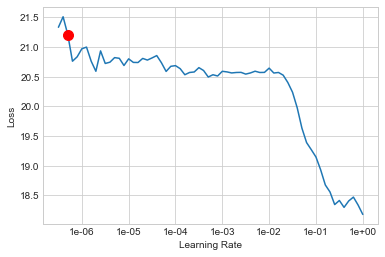

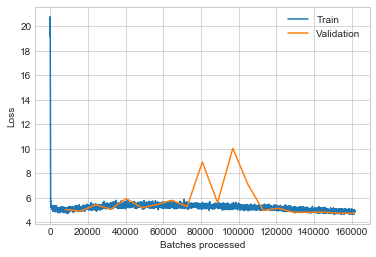

In [23]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(p / 'output/all_resolutions_stdout01.log')
fh.setLevel(logging.DEBUG) 
logger.addHandler(fh)

class L1LossFlat(nn.L1Loss):
    def forward(self, input: Tensor, target: Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

NG = [2]
NR = [0.001]
# NG = [6, 5, 4]
# NR = [0.01, 0.007, 0.004]
bnd1 = 3
for ith, ires in enumerate(NR):  # different resolutions
    in_file = str(p / f"output/africa25m_{ires}deg_training_samples_xfiles.pqt")
    df0 = pd.read_parquet(in_file)

    imgsize = int(np.ceil(ires / 0.0002246))
    logger.debug(imgsize)
    x_file = str(p / "alos2africa_ds.zarr")
    x1path = str(p / f"training_{ires}")
    data = adl.get_databunch_from_df_training(
        df0,
        x1path,
        label="mch",
        test_df=None,
        dbsize=imgsize,
        bs=32,
    )
#     data.show_batch(figsize=(10, 10))
#     plt.savefig(p / f"output/data_batch_{ires}deg.png", dpi=150)

#     data = data.normalize()
#     model2 = models.WideResNet(
#         num_groups=6,
#         N=3,
#         num_classes=1,
#         start_nf=bnd1 * 4,
#         k=1,
#         n_in_channels=bnd1,
#         drop_p=0.2,
#     )
#     learn = Learner(
#         data,
#         model2,
#         loss_func=L1LossFlat(),
#         metrics=[mean_squared_error],
#         path=str(p / f"output/learn_{ires}deg"),
#     )
    learn = cnn_learner(
        data, models.resnet34, pretrained=False, 
        loss_func=L1LossFlat(), lin_ftrs=[512], ps=0.2,
        metrics=[mean_squared_error],
        path=str(p / f"output/learn_{ires}deg2"))
    learn.lr_find(end_lr=1000)
    learn.recorder.plot(suggestion=True, skip_start=5, skip_end=8)
    min_grad_lr = learn.recorder.min_grad_lr
    min_grad_lr
    logger.debug(learn.summary())
    layers = flatten_model(learn.model)
    custom_hook = callbacks.hook_output(layers[-8])
    learn.fit_one_cycle(20, 0.05)
    learn.recorder.plot_losses()


In [24]:
    preds, y = learn.get_preds()

In [25]:
    preds.shape

torch.Size([64625, 1])

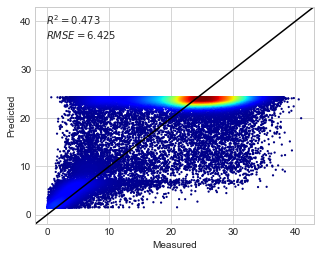

this Learner object self-destroyed - it still exists, but no longer usable


In [26]:
    y = y.numpy().flatten()
    preds = preds.numpy().flatten()
    gridm.density_scatter_plot(
        y,
        preds,
        file_name=str(p / f"output/learn_{ires}deg2_alos_val_densityplot.png"),
    )
    learn.save("trained_model", return_path=True)
    learn.destroy()
    

MultiChannelImageListFolder (323126 items)
Image (3, 5, 4),Image (3, 5, 4),Image (3, 5, 5),Image (3, 4, 4),Image (3, 5, 5)
Path: E:\data00\a1902alostexture\data3\training_0.001


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 258501 out of 258501 | elapsed: 50.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 64625 out of 64625 | elapsed: 14.9min finished


(323126, 1024)
(323126, 3)
(323126,)
Grid Search for pipeline of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:   50.9s finished


{'learn__max_depth': 6, 'learn__min_samples_split': 12, 'learn__n_estimators': 500, 'pca': None}
-38.72885078571973
40.07203447683425
cross-validated score: [-40.219335 -39.856613 -40.144489]
mean cv score: -40.073478983052105
(258500, 1)
test score 0: 40.14075913580252


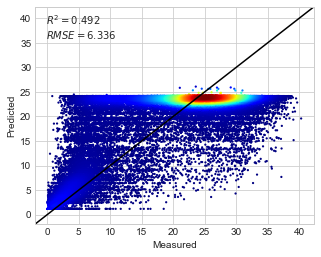

Grid Search for pipeline of RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]), cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   28.5s finished


{'poly': PolynomialFeatures(degree=1, include_bias=True, interaction_only=False), 'scale': None}
-42.5170881599814


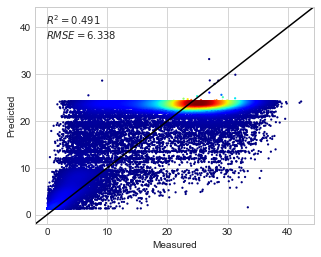

Grid Search for pipeline of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:   12.6s finished


{'learn__max_depth': 6, 'learn__min_samples_split': 12, 'learn__n_estimators': 500, 'pca': None}
-38.15312259166759
40.131330802741154
cross-validated score: [-40.295837 -39.934782 -40.161801]
mean cv score: -40.1308065262164
(258500, 1)
test score 0: 40.11544372987927


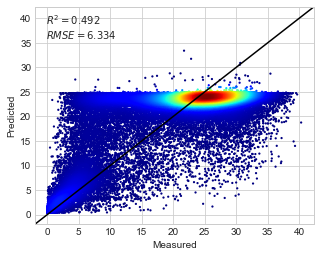

In [27]:
from joblib import Parallel, delayed

class L1LossFlat(nn.L1Loss):
    def forward(self, input: Tensor, target: Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

def get_pred_layers(Xi, learn, custom_hook):
    learn.predict(Xi[0])
    a0 = custom_hook.stored[0]
    b0 = Xi[1].data
    c0 = Xi[0].data.mean(dim=[1, 2])
    return a0, b0, c0

# NR = [0.01, 0.007, 0.004]
NR = [0.001]
bnd1 = 3
for ith, ires in enumerate(NR):  # different resolutions
    in_file = str(p / f"output/africa25m_{ires}deg_training_samples_xfiles.pqt")
    df0 = pd.read_parquet(in_file)
    imgsize = int(np.ceil(ires / 0.0002246))
    x_file = str(p / "alos2africa_ds.zarr")
    x1path = str(p / f"training_{ires}")
    data = adl.get_databunch_from_df_training(
        df0,
        x1path,
        label="mch",
        test_df=None,
        dbsize=imgsize,
        bs=32,
    )
    bnd1 = 3
#     model2 = models.WideResNet(
#         num_groups=6,
#         N=3,
#         num_classes=1,
#         start_nf=bnd1 * 4,
#         k=1,
#         n_in_channels=bnd1,
#         drop_p=0.2,
#     )
#     learn = Learner(data, model2, loss_func=L1LossFlat(), metrics=[mean_squared_error])
    learn = cnn_learner(
        data, models.resnet34, pretrained=False, 
        loss_func=L1LossFlat(), lin_ftrs=[512], ps=0.2,
        metrics=[mean_squared_error])
    learn = learn.load(str(p / f"output/learn_{ires}deg2/models/trained_model"))
    layers = flatten_model(learn.model)
    custom_hook = callbacks.hook_output(layers[-8])
    
    X = learn.data.train_ds
    res = Parallel(n_jobs=1, verbose=1)(delayed(get_pred_layers)(Xi, learn, custom_hook) for Xi in X)
    a1 = [item[0] for item in res]
    b1 = [item[1] for item in res]
    c1 = [item[2] for item in res]

    X = learn.data.valid_ds
    res = Parallel(n_jobs=1, verbose=1)(delayed(get_pred_layers)(Xi, learn, custom_hook) for Xi in X)
    a2 = [item[0] for item in res]
    b2 = [item[1] for item in res]
    c2 = [item[2] for item in res]
    a = a1 + a2
    b = b1 + b2
    c = c1 + c2

    X1 = torch.stack(a).cpu().numpy()
    print(X1.shape)
    X2 = torch.stack(c).cpu().numpy()
    print(X2.shape)
    y = np.stack(b)
    print(y.shape)
    
    model_regress1 = gridm.data_train(
        X1, y, outname=str(p / f"output/rfcnn_{ires}deg2_alos")
    )
    model_regress2 = gridm.data_train_ridge(
        X1, y, outname=str(p / f"output/ridgecnn_{ires}deg2_alos")
    )
    model_regress3 = gridm.data_train(
        X2, y, outname=str(p / f"output/rfmean_{ires}deg2_alos")
    )

## Multi-resolution comparison

MultiChannelImageListFolder (1062 items)
Image (3, 66, 66),Image (3, 67, 67),Image (3, 67, 66),Image (3, 66, 67),Image (3, 67, 67)
Path: E:\data00\a1902alostexture\data3\training_0.015


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 850 out of 850 | elapsed:   17.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 212 out of 212 | elapsed:    5.3s finished


(1062, 1024)
(1062, 3)
(1062,)
Grid Search for pipeline of RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]), cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   30.5s finished


{'poly': PolynomialFeatures(degree=1, include_bias=True, interaction_only=False), 'scale': None}
-14.296050167179283


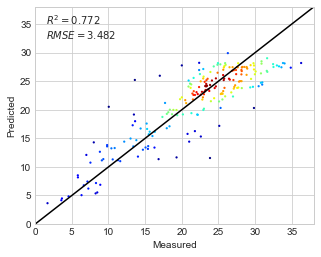

Grid Search for pipeline of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:   12.3s finished


{'learn__max_depth': 12, 'learn__min_samples_split': 2, 'learn__n_estimators': 500, 'pca': None}
-17.052281756140637
18.5939356205263
cross-validated score: [-17.036603 -19.167466 -20.672158]
mean cv score: -18.958742476696585
(849, 1)
test score 0: 30.53846874579675


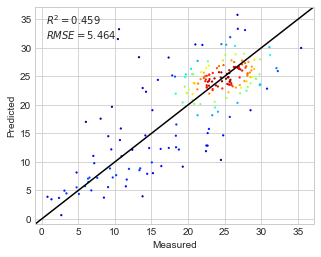

MultiChannelImageListFolder (2768 items)
Image (3, 44, 45),Image (3, 45, 45),Image (3, 45, 45),Image (3, 44, 45),Image (3, 44, 44)
Path: E:\data00\a1902alostexture\data3\training_0.01


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2215 out of 2215 | elapsed:   35.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 553 out of 553 | elapsed:   14.5s finished


(2768, 1024)
(2768, 3)
(2768,)
Grid Search for pipeline of RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]), cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   30.7s finished


{'poly': PolynomialFeatures(degree=1, include_bias=True, interaction_only=False), 'scale': None}
-15.475856711904314


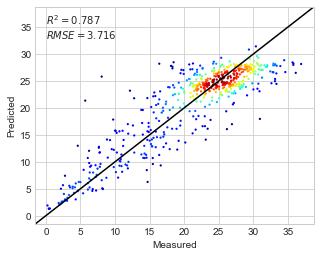

Grid Search for pipeline of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:   12.3s finished


{'learn__max_depth': 12, 'learn__min_samples_split': 12, 'learn__n_estimators': 500, 'pca': None}
-19.77174628299811
16.359697233597856
cross-validated score: [-15.418499 -17.04997  -16.752432]
mean cv score: -16.406967101629306
(2214, 1)
test score 0: 23.029488623926845


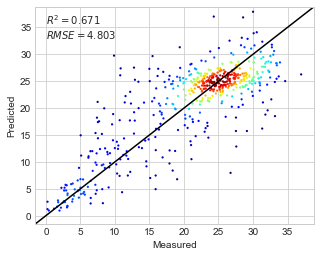

MultiChannelImageListFolder (6011 items)
Image (3, 31, 31),Image (3, 31, 31),Image (3, 31, 31),Image (3, 31, 31),Image (3, 32, 31)
Path: E:\data00\a1902alostexture\data3\training_0.007


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4809 out of 4809 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1202 out of 1202 | elapsed:   27.7s finished


(6011, 1024)
(6011, 3)
(6011,)
Grid Search for pipeline of RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]), cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   31.5s finished


{'poly': PolynomialFeatures(degree=1, include_bias=True, interaction_only=False), 'scale': None}
-19.849813441175485


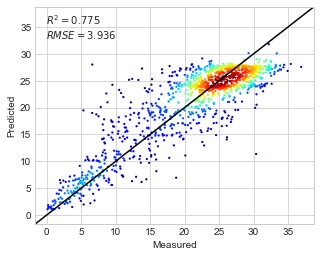

Grid Search for pipeline of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:   12.2s finished


{'learn__max_depth': 6, 'learn__min_samples_split': 2, 'learn__n_estimators': 500, 'pca': None}
-21.737576962378025
19.609234964695936
cross-validated score: [-19.778304 -20.161259 -18.950473]
mean cv score: -19.630012106533588
(4808, 1)
test score 0: 20.168883066797314


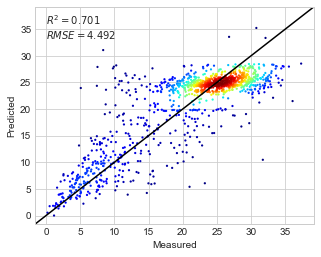

MultiChannelImageListFolder (19203 items)
Image (3, 18, 18),Image (3, 18, 17),Image (3, 18, 18),Image (3, 18, 18),Image (3, 18, 18)
Path: E:\data00\a1902alostexture\data3\training_0.004


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 15363 out of 15363 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3840 out of 3840 | elapsed:  1.6min finished


(19203, 1024)
(19203, 3)
(19203,)
Grid Search for pipeline of RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]), cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   30.3s finished


{'poly': PolynomialFeatures(degree=1, include_bias=True, interaction_only=False), 'scale': None}
-21.709053330623473


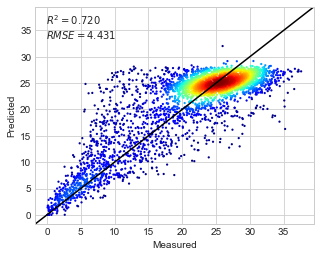

Grid Search for pipeline of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:   12.2s finished


{'learn__max_depth': 9, 'learn__min_samples_split': 12, 'learn__n_estimators': 500, 'pca': None}
-23.775372149068357
21.643296914059693
cross-validated score: [-21.212513 -22.619469 -21.105889]
mean cv score: -21.645957118208575
(15362, 1)
test score 0: 24.896651900483896


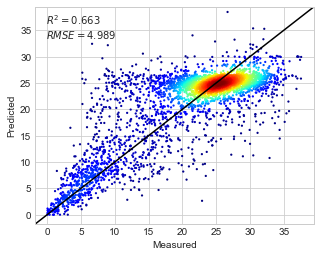

MultiChannelImageListFolder (323126 items)
Image (3, 5, 4),Image (3, 5, 4),Image (3, 5, 5),Image (3, 4, 4),Image (3, 5, 5)
Path: E:\data00\a1902alostexture\data3\training_0.001


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 258501 out of 258501 | elapsed: 54.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 64625 out of 64625 | elapsed: 30.1min finished


(323126, 1024)
(323126, 3)
(323126,)
Grid Search for pipeline of RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]), cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   56.2s finished


{'poly': PolynomialFeatures(degree=1, include_bias=True, interaction_only=False), 'scale': None}
-51.774487101034076


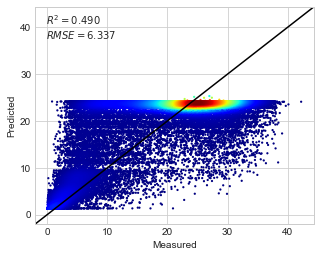

Grid Search for pipeline of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:   22.9s finished


{'learn__max_depth': 6, 'learn__min_samples_split': 12, 'learn__n_estimators': 500, 'pca': None}
-42.41822169680577
40.054855182763475
cross-validated score: [-39.668103 -40.665745 -39.828337]
mean cv score: -40.05406165474934
(258500, 1)
test score 0: 40.37171602110646


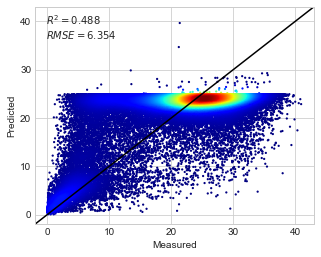

In [29]:
from joblib import Parallel, delayed

class L1LossFlat(nn.L1Loss):
    def forward(self, input: Tensor, target: Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

def get_pred_layers(Xi, learn, custom_hook):
    learn.predict(Xi[0])
    a0 = custom_hook.stored[0]
    b0 = Xi[1].data
    c0 = Xi[0].data.mean(dim=[1, 2])
    return a0, b0, c0

NR = [0.015, 0.01, 0.007, 0.004, 0.001]
bnd1 = 3
r22 = []
rmse2 = []
beta2 = []
r23 = []
rmse3 = []
beta3 = []
for ith, ires in enumerate(NR):  # different resolutions
    in_file = str(p / f"output/africa25m_{ires}deg_training_samples_xfiles.pqt")
    df0 = pd.read_parquet(in_file)
    imgsize = int(np.ceil(ires / 0.0002246))
    x_file = str(p / "alos2africa_ds.zarr")
    x1path = str(p / f"training_{ires}")
    data = adl.get_databunch_from_df_training(
        df0,
        x1path,
        label="mch",
        test_df=None,
        dbsize=imgsize,
        bs=16,
    )
    bnd1 = 3
    learn = cnn_learner(
        data, models.resnet34, pretrained=False, 
        loss_func=L1LossFlat(), lin_ftrs=[512], ps=0.2,
        metrics=[mean_squared_error])
    learn = learn.load(str(p / f"output/learn_{ires}deg2/models/trained_model"))
    layers = flatten_model(learn.model)
    custom_hook = callbacks.hook_output(layers[-8])
    
    X = learn.data.train_ds
    res = Parallel(n_jobs=1, verbose=1)(delayed(get_pred_layers)(Xi, learn, custom_hook) for Xi in X)
    a1 = [item[0] for item in res]
    b1 = [item[1] for item in res]
    c1 = [item[2] for item in res]

    X = learn.data.valid_ds
    res = Parallel(n_jobs=1, verbose=1)(delayed(get_pred_layers)(Xi, learn, custom_hook) for Xi in X)
    a2 = [item[0] for item in res]
    b2 = [item[1] for item in res]
    c2 = [item[2] for item in res]
    a = a1 + a2
    b = b1 + b2
    c = c1 + c2

    X1 = torch.stack(a).cpu().numpy()
    print(X1.shape)
    X2 = torch.stack(c).cpu().numpy()
    print(X2.shape)
    y = np.stack(b)
    print(y.shape)
    
    model_regress2, r2, rmse, beta0 = gridm.data_train_ridge(
        X1, y, outname=str(p / f"output/ridgecnn_{ires}deg2_alos")
    )
    r22.append(r2)
    rmse2.append(rmse)
    beta2.append(beta0)
    model_regress3, r2, rmse, beta0 = gridm.data_train(
        X2, y, outname=str(p / f"output/rfmean_{ires}deg2_alos")
    )
    r23.append(r2)
    rmse3.append(rmse)
    beta3.append(beta0)
    

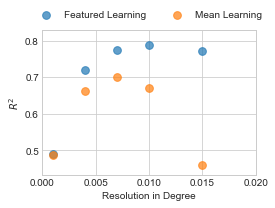

In [30]:
fig0 = plt.figure(figsize=(4, 3))
plt.scatter(NR, r22, s=60, alpha=0.7)
plt.scatter(NR, r23, s=60, alpha=0.7)
plt.xlabel("Resolution in Degree")
plt.ylabel(f"$R^2$")
plt.xlim([0, 0.02])
plt.legend({'Featured Learning', 'Mean Learning'}, loc='lower center', bbox_to_anchor= (0.5, 1.01), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig(p / f"output/multi_res_R2.png", dpi=150)
plt.show()


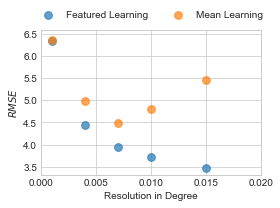

In [31]:
fig0 = plt.figure(figsize=(4, 3))
plt.scatter(NR, rmse2, s=60, alpha=0.7)
plt.scatter(NR, rmse3, s=60, alpha=0.7)
plt.xlabel("Resolution in Degree")
plt.ylabel(f"$RMSE$")
plt.xlim([0, 0.02])
plt.legend({'Featured Learning', 'Mean Learning'}, loc='lower center', bbox_to_anchor= (0.5, 1.01), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig(p / f"output/multi_res_rmse.png", dpi=150)
plt.show()


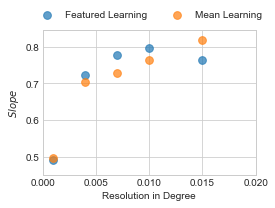

In [32]:
fig0 = plt.figure(figsize=(4, 3))
plt.scatter(NR, beta2, s=60, alpha=0.7)
plt.scatter(NR, beta3, s=60, alpha=0.7)
plt.xlabel("Resolution in Degree")
plt.ylabel(f"$Slope$")
plt.xlim([0, 0.02])
plt.legend({'Featured Learning', 'Mean Learning'}, loc='lower center', bbox_to_anchor= (0.5, 1.01), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig(p / f"output/multi_res_slope.png", dpi=150)
plt.show()


## Conclusion

